# Project: Identify Customer Segments

In this project, I will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [36]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import json

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [417]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [38]:
# Check the structure of theazdias data after it's loaded to get a first overview
print(azdias.shape)
print(azdias.info())

(891221, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB     

In [39]:
# getting first overview of the features
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [40]:
# Check the structure of the feature summary file data after it's loaded to get a first overview
print(feat_info.shape)
print(feat_info.info())

(85, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB
None



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [41]:
# Identify missing or unknown data values and convert them to NaNs.
print('Total number of missing or unknown data before converting to NaN: {}'.format(azdias.isnull().sum().sum()))

Total number of missing or unknown data before converting to NaN: 4896838


In [42]:
# choosing a value in order to perfom sanity checks later
azdias[azdias['CAMEO_DEU_2015']== 'XX'].sample(1)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
513546,-1,4,2,4.0,4,1,5,1,1,5,...,1.0,3.0,3.0,2.0,4.0,4.0,2.0,4.0,7.0,3.0


In [419]:
azdias['CAMEO_DEUG_2015'][430014]

'X'

In [44]:
# function for parsing and replacing the identified values with nan in the df azdidas
for index in range(len(feat_info)):
    nan_values = feat_info.iloc[index]['missing_or_unknown']
    nan_values = nan_values.strip('[]').split(',')
    nan_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in nan_values]
    if nan_values != ['']:
        azdias = azdias.replace({feat_info.iloc[index]['attribute']: nan_values}, np.nan)
        
#(source inspiration: https://github.com/swang13/identify-customer-segments/blob/master/Identify_Customer_Segments.ipynb)

In [50]:
#sanity check
azdias['CAMEO_DEUG_2015'][430014]

nan

In [51]:
print('Total number of missing or unknown data after converting missing/unknown values to NaN: {}'.format(azdias.isnull().sum().sum()))

Total number of missing or unknown data after converting missing/unknown values to NaN: 5035304


The total amount of missing data has of coursed increased after converting all missing data into nan. In the next step I while have a closer look at the missing data and its distribution

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
MOBI_REGIO        14.959701
KBA05_ANTG4       14.959701
KBA05_ANTG3       14.959701
KBA05_ANTG2       14.959701
KBA05_ANTG1       14.959701
KBA05_GBZ         14.959701
PLZ8_ANTG2        13.073637
dtype: float64


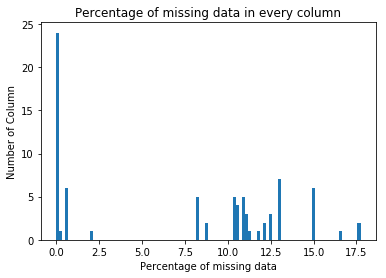

In [52]:
# Perform an assessment of how much missing data there is in each column of the
# dataset by displaying the percentag of the missing values in each colum

percent_missing_column = (azdias.isnull().sum())/(azdias.shape[0])*100
print(percent_missing_column.sort_values(ascending=False).head(10))

#Plotting the missing data
plt.hist(percent_missing_column, bins=100)
plt.title('Percentage of missing data in every column')
plt.xlabel('Percentage of missing data')
plt.ylabel('Number of Column');

In [53]:
# Investigate patterns in the amount of missing data in each column.
# converting the series into a df for further investigation
percent_missing_column = pd.DataFrame(percent_missing_column, columns=['missing_data'])
print(percent_missing_column.describe())
print('Percentage of columns with missing data: {}'.format(percent_missing_column[percent_missing_column['missing_data']!= 0].shape[0]/percent_missing_column.shape[0]))
print('Percentage of columns with no missing data: {}'.format(1-percent_missing_column[percent_missing_column['missing_data']!= 0].shape[0]/percent_missing_column.shape[0]))


       missing_data
count     79.000000
mean       7.151764
std        6.087588
min        0.000000
25%        0.000000
50%       10.451729
75%       12.145080
max       17.735668
Percentage of columns with missing data: 0.6962025316455697
Percentage of columns with no missing data: 0.30379746835443033


The analyis shows that just 28% of the columns have no missing data, but "just" six of the 85 columns have missing data over 30%
The columns with the highest percentage of missing data (>30%) are
- TITEL_KZ          
- AGER_TYP          
- KK_KUNDENTYP      
- KBA05_BAUMAX      
- GEBURTSJAHR       
- ALTER_HH

The decision which columns need to be dropped isnt easy and really depends on what you would like to achieve with the data. But it seems unreasonable in this case to keep columns that over 30% missing data.


In [420]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP', 'KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'], axis=1)
#double check operation
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The total number of missing or unknown data in the azdias data set (after converting missing/unknown values to NaN) is 8373929 which is around 11% of the total oberservations: (891211 persons (rows) * 85 columns). 

The furthter analyis of the missing data for each column showed that just 28% of the columns have no missing data (24 columns), but "just" six of the 85 columns have missing data over 30%
In total, 61 of the 85 columns have missing data (72% of all columns)

The columns with the highest percentage of missing data (> 30%) are:

- TITEL_KZ          
- AGER_TYP          
- KK_KUNDENTYP      
- KBA05_BAUMAX      
- GEBURTSJAHR       
- ALTER_HH
 

#### The decision which columns need to be dropped isnt easy and really depends on what you would like to achieve with the data. But it seems unreasonable in this case to keep columns that have over 30% missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [55]:
# inspecting how much data is missing in each row of the
# function for calculating the percentage of missing data for each row

def missing_values_row(row):
    return (row.isnull().sum()/azdias.shape[1])*100
    
azdias['missing_values_rows'] = azdias.apply(missing_values_row, axis=1)


In [56]:
# displaying row with the missing value for each row
print(azdias.shape)
azdias['missing_values_rows'].sort_values(ascending=False).head()

(891221, 80)


643174    62.025316
732775    62.025316
472919    60.759494
183108    59.493671
139316    59.493671
Name: missing_values_rows, dtype: float64

In [57]:
#sanity check
sanity_check = azdias.loc[643174]
sanity_check.isnull().sum()/79 * 100

62.025316455696199

In [58]:
azdias['missing_values_rows'].describe()

count    891221.000000
mean          7.151764
std          16.752768
min           0.000000
25%           0.000000
50%           0.000000
75%           3.797468
max          62.025316
Name: missing_values_rows, dtype: float64

In [59]:
#calculatig the percentage of rows that have missing data over the mean and that have no missing data
missing_over_mean = (azdias[azdias['missing_values_rows'] > azdias['missing_values_rows'].mean()]).shape[0] / azdias.shape[0] * 100
missing_under_mean = (azdias[azdias['missing_values_rows'] == 0.00]).shape[0] / azdias.shape[0] * 100

#printing out the results
print('Percentage of rows with missing data over mean: {}'.format(missing_over_mean))
print('Percetage of rows with no missing data: {}'.format(missing_under_mean))

Percentage of rows with missing data over mean: 19.25414683899953
Percetage of rows with no missing data: 69.9275488346886


#### The are several rows that have quite high number of missing rows, whereby the majority has no missing data: around 70%.

#### I will devide the data into two subsets by the mean (7.06%): one subset with rows that has missing data under the mean and one that has missing data over the mean (which is around 20% of the rows)

In [60]:
# Writing code to divide the data into two subsets based on the number of missing
# values in each row.
#azdias_over_mean - subset with rows that has missing data over mean
#azdias_under_mean - subset with rows that has missing data under mean

azdias_over_mean = azdias.loc[azdias['missing_values_rows'] > azdias['missing_values_rows'].mean()]
azdias_under_mean = azdias.loc[azdias['missing_values_rows'] < azdias['missing_values_rows'].mean()]


In [61]:
#sanity check
print((azdias_over_mean['missing_values_rows'] > 7.06).all())
print((azdias_under_mean['missing_values_rows'] < 7.06).all())

True
True


In [62]:
# function for comparing the distribution of the two subsets
base_color = sns.color_palette()[0]

def comparsion_distr (column_1, column_2):
    #setting up the subplots
    fig = plt.subplots(nrows=1, ncols=1, figsize=(20,5))
    
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=column_1, data=azdias_over_mean, color=base_color)
    plt.title('Data with many missing values')

    plt.subplot(1, 2, 2)
    sns.countplot(x=column_2, data=azdias_under_mean, color=base_color)
    plt.title('Data with few or no missing values')

    plt.show()

In [63]:
#randomly choosing 5 columns from the subset with many missing values for the comparsion
random.sample(list(azdias_over_mean.columns),5)

['ANREDE_KZ',
 'FINANZ_HAUSBAUER',
 'GFK_URLAUBERTYP',
 'ANZ_HH_TITEL',
 'CAMEO_DEUG_2015']

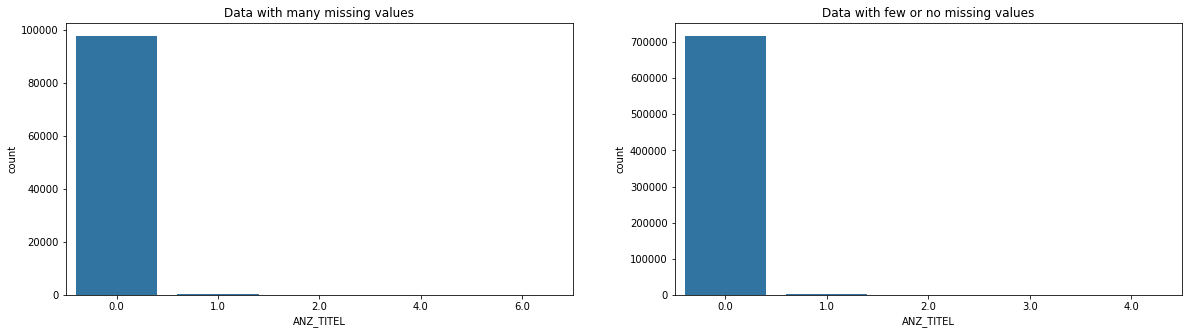

In [64]:
#comparing the subsets for the column 'ANZ_TITEL'
comparsion_distr(azdias_over_mean.ANZ_TITEL, azdias_under_mean.ANZ_TITEL)

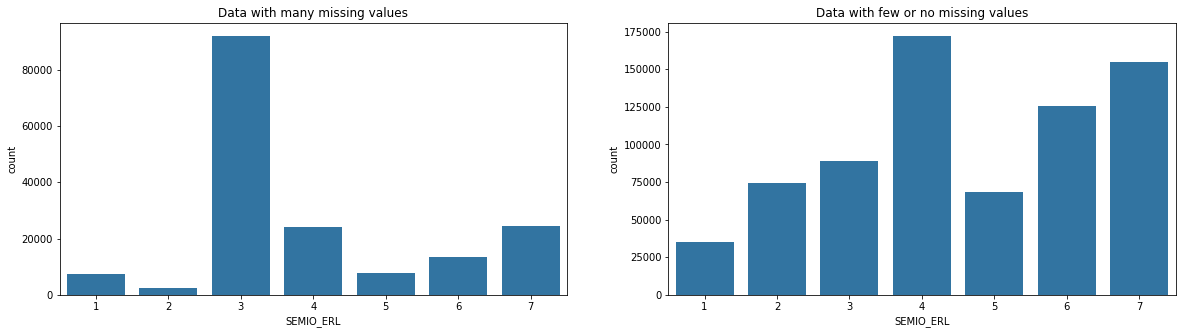

In [65]:
#comparing the subsets for the column 'SEMIO_ERL'
comparsion_distr(azdias_over_mean.SEMIO_ERL, azdias_under_mean.SEMIO_ERL)

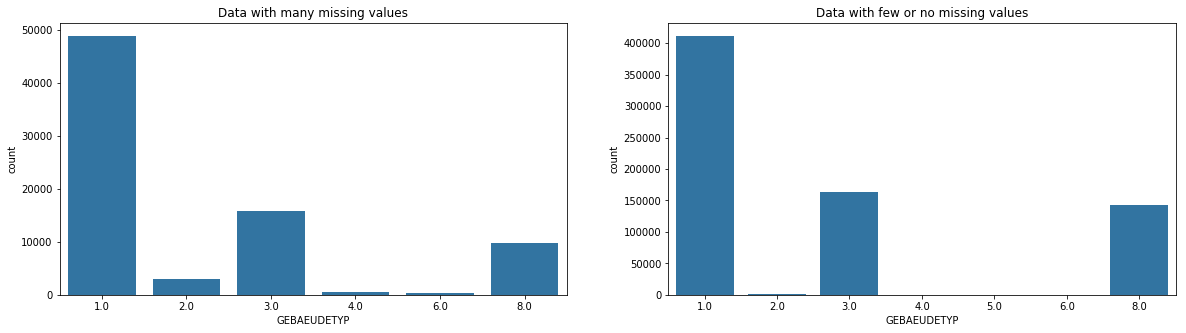

In [66]:
#comparing the subsets for the column 'GEBAEUDETYP'
comparsion_distr(azdias_over_mean.GEBAEUDETYP, azdias_under_mean.GEBAEUDETYP)

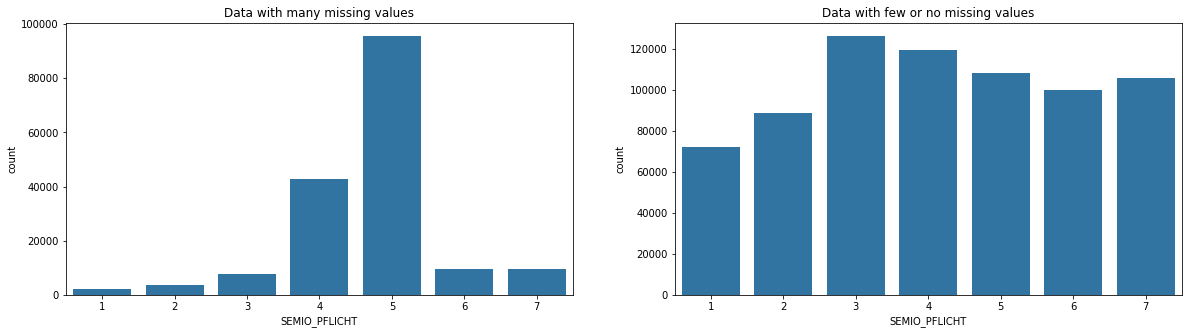

In [67]:
#comparing the subsets for the column 'SSEMIO_PFLICHT'
comparsion_distr(azdias_over_mean.SEMIO_PFLICHT, azdias_under_mean.SEMIO_PFLICHT)

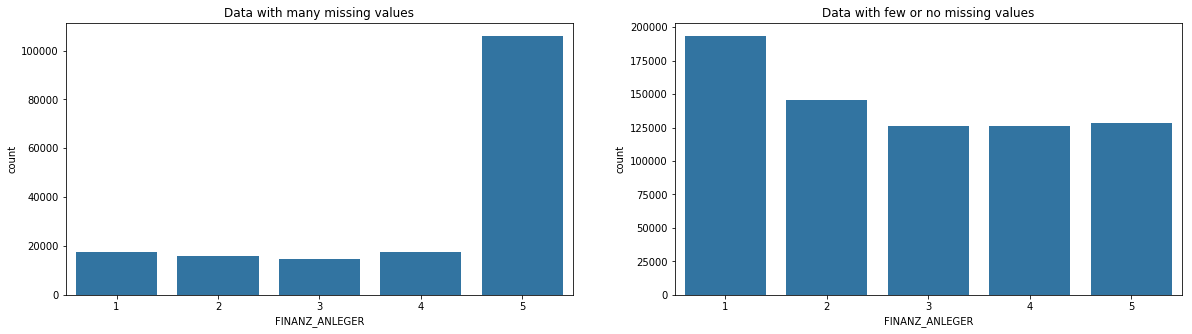

In [68]:
#comparing the subsets for the column 'FINANZ_ANLEGER'
comparsion_distr(azdias_over_mean.FINANZ_ANLEGER, azdias_under_mean.FINANZ_ANLEGER)

#### The comparsion of the 5 randomly chosen columns gives me mixed results. While the first three columns ('ANZ_TITEL', 'SEMIO_ERL', 'GEBAEUDETYP') doesnt show much difference in the distribution, shows the analysis of 'SEMIO_PFLICHT', 'FINANZ_ANLEGER' that there is a huge difference in the distribution based on the subset. Therefore I will continue with the subset with few or no missing data

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [69]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### In total, the data has 21 categorical variables and 7 mixed variables

In [70]:
azdias_under_mean.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,missing_values_rows
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0


In [71]:
#getting all features of azdias_under_mean as a list
features_list = list(azdias_under_mean.columns)

In [72]:
# in the first step I need to get rid of all attributes in feat_info that are not in the subset

#getting all features of azdias_under_mean as a list
features_list = list(azdias_under_mean.columns)

#getting all features of featurw_info that are also in our chosen subset (azdias_under_mean)
cat_variables = feat_info.loc[feat_info['type'].isin(['categorical'])]
cat_variables_names = cat_variables[cat_variables['attribute'].isin(features_list)]
cat_variables_names = cat_variables_names['attribute']

In [73]:
#checking which of the features are binary and which are mulit-level
binary = []
multi_level = []
for attribute in cat_variables_names:
    if (len(azdias_under_mean[attribute].unique()) == 2):
        binary.append(attribute)
    elif (len(azdias_under_mean[attribute].unique()) > 2):
        multi_level.append(attribute)

print('features that are binary {}'.format(binary))
print('\n')
print('features that are mulit_level {}'.format(multi_level))

features that are binary ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


features that are mulit_level ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [74]:
# having a closer look at the binary features to identify the one which is not binary
print(azdias_under_mean[['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']].sample(1))

        ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ OST_WEST_KZ
259676          2                 0      0.0           O


'OST_WEST_KZ' is a binary variable that takes on non-numeric values:
-  O: East (GDR)
-  W: West (FRG)

I will in the next step re-encode the values as numbers as follows:
- O = 0
- W = 1

In [75]:
#re_encoding_values = {'O':0, 'W':1}
azdias_under_mean['OST_WEST_KZ'] = azdias_under_mean['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
#sanity check
azdias_under_mean['OST_WEST_KZ'].values


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([1, 1, 1, ..., 1, 1, 1])

In [76]:
# getting a overview over the multi-level categoricals
for i in multi_level:
    print('\n')
    print(azdias_under_mean[i].value_counts(sort=True))



4.0    181923
3.0    135165
2.0    133034
5.0     93944
6.0     89399
1.0     86159
Name: CJT_GESAMTTYP, dtype: int64


6    277311
1    168290
5     99698
2     93959
4     51158
3     29208
Name: FINANZTYP, dtype: int64


12.0    113937
10.0     94543
8.0      77583
11.0     69363
5.0      66421
4.0      57721
9.0      50166
3.0      49639
1.0      46444
7.0      37156
2.0      32790
6.0      23861
Name: GFK_URLAUBERTYP, dtype: int64


1.0     367815
10.0    119556
2.0      89540
11.0     45700
8.0      19518
7.0      16286
4.0      10469
5.0      10317
9.0       9797
6.0       6940
3.0       4111
Name: LP_FAMILIE_FEIN, dtype: int64


1.0    367815
5.0    175053
2.0     89540
4.0     42744
3.0     24897
Name: LP_FAMILIE_GROB, dtype: int64


1.0     199190
9.0     117022
10.0    103339
2.0      94397
4.0      69138
3.0      66260
6.0      26334
5.0      22061
8.0      13495
7.0       8388
Name: LP_STATUS_FEIN, dtype: int64


1.0    293587
2.0    157459
4.0    130517
5.0    103339
3.

#### I dont want to drop variables for convience, so I will keep most of the variables for now. There are some variables that measure the same but in different depth (detailed scale and rough scale). It seems reasonable to just keep the ones with the rough scale since we would like to cluster the data and dont need detailed scale variables. I will drop therefore the following features:

 - LP_LEBENSPHASE_FEIN
 - LP_FAMILIE_FEIN
 - LP_STATUS_FEIN
 - CAMEO_DEU_2015
 


In [77]:
# dropping detailed scaled features from the sub set
azdias_under_mean = azdias_under_mean.drop(['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)

In [78]:
#sanity check
azdias_under_mean.shape

(719624, 76)

In [79]:
# re-encoding the remaining multi-level categoricals
# creating new df with the multi-level categorials 
categorical_features = azdias_under_mean[['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']]
# converting to list
categorical_features_list = categorical_features.columns.tolist()

#### Since the dataframe includes nan values which can not be handled by the onehotencoder, I decided to use the the pd.get_dummies function instead

In [80]:
azdias_under_mean = pd.get_dummies(azdias_under_mean, columns=categorical_features_list)

In [81]:
# checking if operation was succesfull
azdias_under_mean.sample(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
741062,1.0,1,2,5,2,4,3,3,0,1.0,...,0,0,0,0,0,0,0,0,0,1
136229,3.0,1,4,2,4,2,2,2,0,3.0,...,0,0,1,0,0,0,0,0,0,0
620659,1.0,2,1,5,1,3,4,3,0,1.0,...,1,0,0,0,0,0,0,0,0,1
405568,4.0,1,2,4,2,2,4,2,0,2.0,...,0,0,0,0,0,0,0,0,1,0
261360,2.0,1,5,2,4,2,3,1,1,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

 - I re-encoded the the binary variable that where not numerical
 - I dropped the fine scaled features and kept just the rough scaled features since its fits the clustering approach better
 - I re-encoded the remaining multi-level categoricals with pd.get_dummies

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [82]:
#Getting a first over -view over the mixed features
mixed_variables = feat_info.loc[feat_info['type'].isin(['mixed'])]
mixed_variables_names = mixed_variables[mixed_variables['attribute'].isin(features_list)]
mixed_variables_names = mixed_variables_names['attribute']
mixed_variables_names
mixed_variables

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


LP_LEBENSPHASE_GROB, PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 needs to be engineered since they combine several dimensions

In [83]:
# Investigate "LP_LEBENSPHASE_GROB"
azdias_under_mean.LP_LEBENSPHASE_GROB.value_counts()


2.0     144805
1.0     126190
3.0      96820
12.0     65514
4.0      47222
9.0      43857
5.0      42318
10.0     37200
11.0     28481
6.0      24897
8.0      23006
7.0      19738
Name: LP_LEBENSPHASE_GROB, dtype: int64

the variable "LP_LEBENSPHASE_GROB" is hard to re-engineer since not all values contain information about all the dimensions: for example "6: single parents" do not include information about the income and 
Furthermore, the information is already included in several other features, so I will drop the column from the df

In [84]:
# dropping LP_LEBENSPHASE_GROB from the data frame
azdias_under_mean = azdias_under_mean.drop('LP_LEBENSPHASE_GROB', axis=1)

In [85]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_under_mean.CAMEO_INTL_2015.value_counts()


51    124571
41     84709
24     81970
14     56623
43     52027
54     42522
25     36138
22     29027
45     24492
13     23488
55     22016
23     19147
52     19044
34     16913
15     15743
31     15498
44     13604
12     11439
35      9558
32      9344
33      8694
Name: CAMEO_INTL_2015, dtype: int64

In [86]:
#creating variabels for decade
wealthy = list(range(11,16))
prosperous = list(range(21,26))
comfortable = list(range(31,36))
less_affluent = list(range(41,46))
poorer = list(range(51,56))

dict_household =  {1 : wealthy,
                   2 : prosperous,
                   3 : comfortable,
                   4 : less_affluent,
                   5 : poorer
                  }

item_dict_household =  {w: k for k, v in dict_household.items() for w in v}
item_dict_household =  json.dumps(item_dict_household)

#creating binary variable for movement
pre_family_single_couples = list(range(11, 56, 10))
young_couples_children = list(range(12, 56, 10))
families_school_age_children = list(range(13, 56, 10))
older_families_couples = list(range(14, 56, 10))
retirement = list(range(15, 56, 10))

dict_status =  {1 : pre_family_single_couples,
                2 : young_couples_children,
                3 : families_school_age_children,
                4 : older_families_couples,
                5 : retirement
                  }

item_dict_status ={w: k for k, v in dict_status.items() for w in v}
item_dict_status =  json.dumps(item_dict_status)

print('dict Status {}'.format(item_dict_status))
print('\n')
print('dict Household {}'.format(item_dict_household))


dict Status {"11": 1, "21": 1, "31": 1, "41": 1, "51": 1, "12": 2, "22": 2, "32": 2, "42": 2, "52": 2, "13": 3, "23": 3, "33": 3, "43": 3, "53": 3, "14": 4, "24": 4, "34": 4, "44": 4, "54": 4, "15": 5, "25": 5, "35": 5, "45": 5, "55": 5}


dict Household {"11": 1, "12": 1, "13": 1, "14": 1, "15": 1, "21": 2, "22": 2, "23": 2, "24": 2, "25": 2, "31": 3, "32": 3, "33": 3, "34": 3, "35": 3, "41": 4, "42": 4, "43": 4, "44": 4, "45": 4, "51": 5, "52": 5, "53": 5, "54": 5, "55": 5}


In [87]:
item_dict_household = {"11": 1, "21": 1, "31": 1, "41": 1, "51": 1, "12": 2, "22": 2, "32": 2, "42": 2, "52": 2, "13": 3, "23": 3, "33": 3, "43": 3, "53": 3, "14": 4, "24": 4, "34": 4, "44": 4, "54": 4, "15": 5, "25": 5, "35": 5, "45": 5, "55": 5}
item_dict_status = {"11": 1, "21": 1, "31": 1, "41": 1, "51": 1, "12": 2, "22": 2, "32": 2, "42": 2, "52": 2, "13": 3, "23": 3, "33": 3, "43": 3, "53": 3, "14": 4, "24": 4, "34": 4, "44": 4, "54": 4, "15": 5, "25": 5, "35": 5, "45": 5, "55": 5}

# replacing the values with the keys of the dicts
azdias_under_mean['CAMEO_INTL_2015_household'] = azdias_under_mean['CAMEO_INTL_2015']
azdias_under_mean['CAMEO_INTL_2015_status'] = azdias_under_mean['CAMEO_INTL_2015']

azdias_under_mean['CAMEO_INTL_2015_household'] = azdias_under_mean['CAMEO_INTL_2015_household'].replace(item_dict_household)
azdias_under_mean['CAMEO_INTL_2015_status'] = azdias_under_mean['CAMEO_INTL_2015_status'].replace(item_dict_status)
# sanity check
print(azdias_under_mean['CAMEO_INTL_2015_household'].value_counts())
azdias_under_mean['CAMEO_INTL_2015_status'].value_counts()


1.0    224778
4.0    211632
5.0    107947
3.0    103356
2.0     68854
Name: CAMEO_INTL_2015_household, dtype: int64


1.0    224778
4.0    211632
5.0    107947
3.0    103356
2.0     68854
Name: CAMEO_INTL_2015_status, dtype: int64

In [88]:
# dropping azdias_under_mean['CAMEO_INTL_2015'] from the df
azdias_under_mean = azdias_under_mean.drop('CAMEO_INTL_2015', axis=1)

In [89]:
azdias_under_mean.sample(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_INTL_2015_household,CAMEO_INTL_2015_status
410219,3.0,1,3,2,5,3,1,5,0,3.0,...,0,0,0,0,0,0,1,0,4.0,4.0
10974,2.0,2,2,3,4,2,2,4,0,2.0,...,0,0,0,0,0,0,0,1,1.0,1.0


In [90]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_under_mean.PRAEGENDE_JUGENDJAHRE.value_counts()

14.0    168815
8.0     130339
5.0      80064
10.0     78492
3.0      50728
15.0     38221
11.0     31951
9.0      31607
6.0      24650
12.0     22855
4.0      19715
1.0      18924
2.0       7044
13.0      5050
7.0       3805
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [91]:
#creating variabels for decade
# 40s(=1),...,90s(=6)
decade_dict = {1: [1, 2], 2: [3, 4], 3: [5, 6, 7], 4: [8, 9], 5: [10, 11, 12, 13], 6:[14, 15]}

item_decade_dict =  {w: k for k, v in decade_dict.items() for w in v}

#creating binary variable for movement
#avantgarde(=0), mainstream(=1)

dict_movement = {0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}

item_dict_movement ={w: k for k, v in dict_movement.items() for w in v}

print('dict Movement{}'.format(item_dict_movement))
print('\n')
print('dict decade {}'.format(item_decade_dict))


dict Movement{1: 0, 3: 0, 5: 0, 8: 0, 10: 0, 12: 0, 14: 0, 2: 1, 4: 1, 6: 1, 7: 1, 9: 1, 11: 1, 13: 1, 15: 1}


dict decade {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}


In [92]:
# replacing the values with the keys of the dicts
azdias_under_mean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_under_mean['PRAEGENDE_JUGENDJAHRE']
azdias_under_mean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_under_mean['PRAEGENDE_JUGENDJAHRE']

azdias_under_mean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_under_mean['PRAEGENDE_JUGENDJAHRE_decade'].replace(item_decade_dict)
azdias_under_mean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_under_mean['PRAEGENDE_JUGENDJAHRE_movement'].replace(item_dict_movement)
# sanity check
print(azdias_under_mean['PRAEGENDE_JUGENDJAHRE_decade'].value_counts())
azdias_under_mean['PRAEGENDE_JUGENDJAHRE_movement'].value_counts()

6.0    207036
4.0    161946
5.0    138348
3.0    108519
2.0     70443
1.0     25968
Name: PRAEGENDE_JUGENDJAHRE_decade, dtype: int64


0.0    550217
1.0    162043
Name: PRAEGENDE_JUGENDJAHRE_movement, dtype: int64

In [93]:
# dropping azdias_under_mean['PRAEGENDE_JUGENDJAHRE'] from the df
azdias_clean = azdias_under_mean.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features
I re-engineered the variables PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 by spliting the information of each variable into two new variables. Then I dropped the original columns from the data frame.

The variable "LP_LEBENSPHASE_GROB" is hard to re-engineer since not all values contain information about all the dimensions: for example "6: single parents" do not include information about the income. 
Furthermore, the information is already included in several other features, so I dropped the column from the df

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [94]:
# checking if the data frame now only has the columns that I want to keep for the analysis later
print(azdias_clean.shape)
print(azdias_clean.info())
list(azdias_clean.columns.values)

(719624, 131)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 719624 entries, 1 to 891220
Columns: 131 entries, ALTERSKATEGORIE_GROB to PRAEGENDE_JUGENDJAHRE_movement
dtypes: float64(43), int64(23), uint8(65)
memory usage: 432.5 MB
None


['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SOHO_KZ',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB'

In [95]:
#droppping the column missing_values_rows from the data frame
azdias_clean = azdias_clean.drop('missing_values_rows', axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [132]:
def clean_data(df):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #function for parsing and replacing the identified values with nan in the df azdidas
    for index in range(len(feat_info)):
        nan_values = feat_info.iloc[index]['missing_or_unknown']
        nan_values = nan_values.strip('[]').split(',')
        nan_values = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in nan_values]
        if nan_values != ['']:
            df = df.replace({feat_info.iloc[index]['attribute']: nan_values}, np.nan)
    
    # remove selected columns and rows, ...
    df = df.drop(['TITEL_KZ','AGER_TYP','KK_KUNDENTYP', 'KBA05_BAUMAX','GEBURTSJAHR', 'ALTER_HH'], axis=1)
    
    # splitting the df into two subsets (one with no or few missing variables, one with a lot of missing data)
    # function for calculating the percentage of missing data for each row
    #def missing_values_row(row):
        #return (row.isnull().sum()/df.shape[1])*100
    
    df['missing_values_rows'] = df.apply(missing_values_row, axis=1)
    df_over_mean = df.loc[df['missing_values_rows'] > df['missing_values_rows'].mean()]
    df_under_mean = df.loc[df['missing_values_rows'] < df['missing_values_rows'].mean()]
    
    # select, re-encode, and engineer column values.
    # re-encode OST_WEST_KZ as numerical binary variable
    #re_encoding_values = {'O':0, 'W':1}
    df_under_mean['OST_WEST_KZ'] = df_under_mean['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
    
    # dropping detailed scaled features from the sub set
    df_under_mean = df_under_mean.drop(['LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1)
    
    # re-encoding the remaining multi-level categoricals
    # creating new df with the multi-level categorials 
    categorical_features = df_under_mean[['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']]
    # converting to list
    categorical_features_list = categorical_features.columns.tolist()
    df_under_mean = pd.get_dummies(df_under_mean, columns=categorical_features_list)
    
    # dropping LP_LEBENSPHASE_GROB from the data frame
    df_under_mean = df_under_mean.drop('LP_LEBENSPHASE_GROB', axis=1)
    
    # re-engeering AMEO_INTL_2015 into two new variables and dropping the orignal colum from the data frame
    item_dict_household = {"11": 1, "21": 1, "31": 1, "41": 1, "51": 1, "12": 2, "22": 2, "32": 2, "42": 2, "52": 2, "13": 3, "23": 3, "33": 3, "43": 3, "53": 3, "14": 4, "24": 4, "34": 4, "44": 4, "54": 4, "15": 5, "25": 5, "35": 5, "45": 5, "55": 5}
    item_dict_status = {"11": 1, "21": 1, "31": 1, "41": 1, "51": 1, "12": 2, "22": 2, "32": 2, "42": 2, "52": 2, "13": 3, "23": 3, "33": 3, "43": 3, "53": 3, "14": 4, "24": 4, "34": 4, "44": 4, "54": 4, "15": 5, "25": 5, "35": 5, "45": 5, "55": 5}
    df_under_mean['CAMEO_INTL_2015_household'] = df_under_mean['CAMEO_INTL_2015']
    df_under_mean['CAMEO_INTL_2015_status'] = df_under_mean['CAMEO_INTL_2015']
    df_under_mean['CAMEO_INTL_2015_household'] = df_under_mean['CAMEO_INTL_2015_household'].replace(item_dict_household)
    df_under_mean['CAMEO_INTL_2015_status'] = df_under_mean['CAMEO_INTL_2015_status'].replace(item_dict_status)
    df_under_mean = df_under_mean.drop('CAMEO_INTL_2015', axis=1)
    
    # re-engeering AMEO_INTL_2015 into two new variables and dropping the orignal colum from the data frame
    #creating variabels for decade
    # 40s(=1),...,90s(=6)
    decade_dict = {1: [1, 2], 2: [3, 4], 3: [5, 6, 7], 4: [8, 9], 5: [10, 11, 12, 13], 6:[14, 15]}
    item_decade_dict =  {w: k for k, v in decade_dict.items() for w in v}

    #creating binary variable for movement
    #avantgarde(=0), mainstream(=1)
    dict_movement = {0: [1, 3, 5, 8, 10, 12, 14], 1: [2, 4, 6, 7, 9, 11, 13, 15]}
    item_dict_movement ={w: k for k, v in dict_movement.items() for w in v}
    
    df_under_mean['PRAEGENDE_JUGENDJAHRE_decade'] = df_under_mean['PRAEGENDE_JUGENDJAHRE']
    df_under_mean['PRAEGENDE_JUGENDJAHRE_movement'] = df_under_mean['PRAEGENDE_JUGENDJAHRE']
    df_under_mean['PRAEGENDE_JUGENDJAHRE_decade'] = df_under_mean['PRAEGENDE_JUGENDJAHRE_decade'].replace(item_decade_dict)
    df_under_mean['PRAEGENDE_JUGENDJAHRE_movement'] = df_under_mean['PRAEGENDE_JUGENDJAHRE_movement'].replace(item_dict_movement)
    df_clean = df_under_mean.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    # Return the cleaned dataframe.
    return df_clean, df_over_mean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [97]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print('Missing values in data frame: {}'.format(azdias_clean.isnull().sum().sum()))
print('Total amount of values in data frame: {}'.format(azdias_clean.shape[0]))

Missing values in data frame: 170459
Total amount of values in data frame: 719624


by dropping all missing values would mean that I would lose around 26% of the values which seems pretty high.
So I will not simple drop the missing values from the data frame but applying an imputer to replace all missing values

In [98]:
# applying imputation on the missing values (strategy='mean')

imputer_mean = Imputer(missing_values=np.nan, strategy='mean', axis=0)
azdias_clean_imputed = pd.DataFrame(imputer_mean.fit_transform(azdias_clean))
# restoring the data frame
azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index

#(source: https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera)

In [99]:
#sanity check
print('Missing values in the imputed data frame: {}'.format(azdias_clean_imputed.isnull().sum().sum()))

Missing values in the imputed data frame: 0


In [100]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_clean_imputed_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean_imputed))
# restoring the data frame
azdias_clean_imputed_scaled.columns = azdias_clean.columns
azdias_clean_imputed_scaled.index = azdias_clean.index
azdias_clean_imputed_scaled.shape

(719624, 130)

### Discussion 2.1: Apply Feature Scaling

In the first step, I applyied an imputer to replace all missing values with the mean.
In the second step I scaled all features with a standard scaler, scaling each feature to mean 0 and standard deviation 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [101]:
# Apply PCA to the data with the help of the do_pca function from the class room

def do_pca (n_components, data):
    
    pca = PCA(n_components)
    data_pca = pca.fit_transform(data)
    return pca, data_pca

In [103]:
# apply PCA for the 130 features in the data set for then Investigating the variance accounted for by each principal component
pca, azdias_clean_imputed_scaled_pca = do_pca (130, azdias_clean_imputed_scaled)

In [421]:
# looking at the features (sanity check)
azdias_clean_imputed_scaled_pca.shape

(719624, 61)

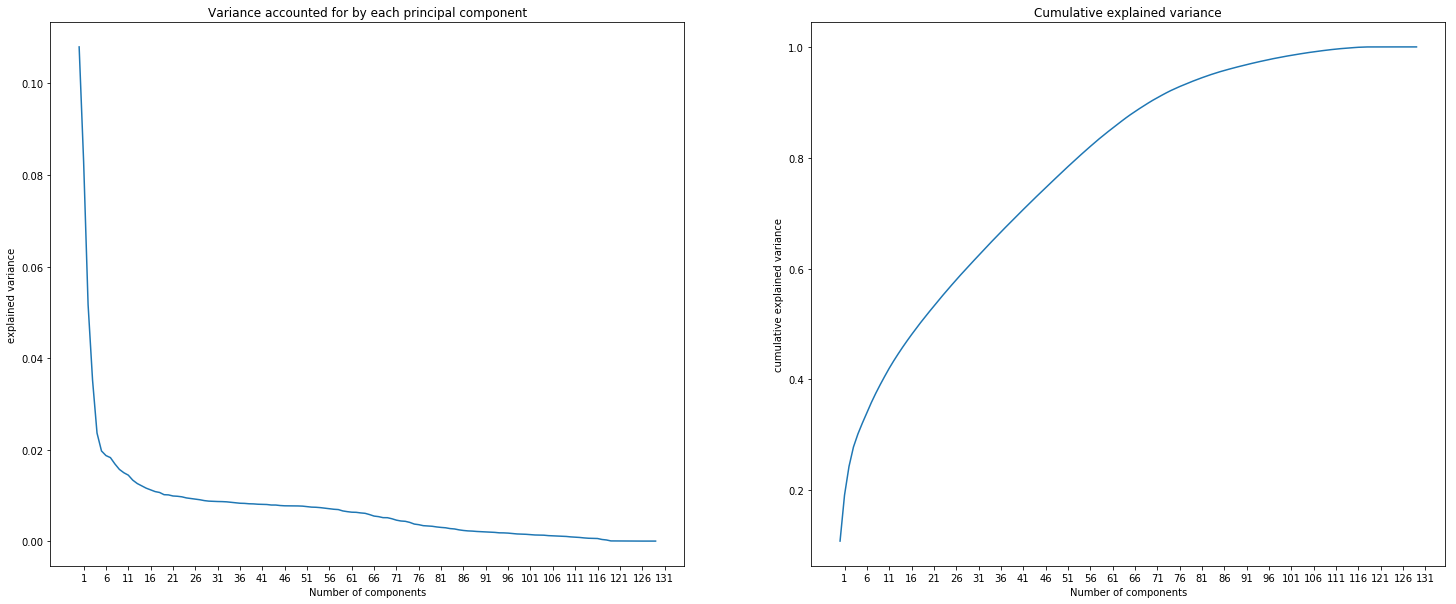

In [104]:
# Investigate the variance accounted for by each principal component.
# plotting the explained variance 
#setting up the subplots
fig = plt.subplots(nrows=1, ncols=1, figsize=(25,10))

plt.subplot(1, 2, 1)
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance accounted for by each principal component')
plt.xlabel('Number of components')
plt.xticks(range(1,132,5))
plt.ylabel('explained variance');


plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Cumulative explained variance')
plt.xlabel('Number of components')
plt.xticks(range(1,132,5))
plt.ylabel('cumulative explained variance');

In [105]:
# how much information (variance) can be attributed to each of the principal component.
pca.explained_variance_ratio_.round(2)

array([ 0.11,  0.08,  0.05,  0.04,  0.02,  0.02,  0.02,  0.02,  0.02,
        0.02,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

The plot on the left shows how much information (variance) can be attributed to each of the principal component.
As one can see, the first component contains 11% of the information, the second 0.08 % etc. 
You can also see that the information each component holds decrease pretty fast. The first 10 components hold 39% of the information (variance). This is display by the "elbow" in the plot.

In [106]:
# culmutive variance 
pca.explained_variance_ratio_.cumsum()

array([ 0.10798908,  0.19094279,  0.24263609,  0.27780989,  0.30141501,
        0.32111181,  0.33980115,  0.35804016,  0.37490114,  0.39056978,
        0.40550865,  0.41991797,  0.43323433,  0.44581509,  0.45789442,
        0.4694591 ,  0.48066162,  0.49148054,  0.50210512,  0.51224563,
        0.52234046,  0.53219672,  0.54199208,  0.55166362,  0.56109787,
        0.57040688,  0.57960682,  0.58864385,  0.59749287,  0.60622609,
        0.61491217,  0.62355986,  0.63218631,  0.64076508,  0.64923628,
        0.65762177,  0.66589202,  0.67413222,  0.68228937,  0.69041859,
        0.69847466,  0.70649902,  0.7144943 ,  0.72237695,  0.73025479,
        0.73802288,  0.7457334 ,  0.75343455,  0.76112532,  0.76880381,
        0.77644198,  0.78396509,  0.79138753,  0.79877725,  0.80608664,
        0.81327886,  0.82034454,  0.82729886,  0.83418634,  0.84077804,
        0.84721385,  0.85352867,  0.85981557,  0.8659715 ,  0.87203822,
        0.87782879,  0.88329411,  0.88863754,  0.8937618 ,  0.89

In [107]:
#how many components need to be kept to explain 85% of the variability in the original dataset?
explained_over_85 = pca.explained_variance_ratio_.cumsum() <= 0.85
print('{} components need to be kept to explain 85% of the variability'.format(explained_over_85.sum()))

61 components need to be kept to explain 85% of the variability


The plot on the left shows the total information (variance) hold by the number of components. The graph is pretty steep in the beginng and flattens after 10 components. 
61 components are needed to explain 85% of the variability of the data set bzw. the first 62 components holding 85% of the information.

In [108]:
# Re-apply PCA to the data with only 61 components
pca, azdias_clean_imputed_scaled_pca = do_pca (61, azdias_clean_imputed_scaled)

In [109]:
#sanity check
print(azdias_clean_imputed_scaled_pca.shape)
pca.explained_variance_ratio_.cumsum()

(719624, 61)


array([ 0.10798908,  0.19094279,  0.24263609,  0.27780989,  0.30141501,
        0.32111179,  0.33980108,  0.35804004,  0.37490091,  0.39056952,
        0.40550779,  0.41991641,  0.43323206,  0.445812  ,  0.45789035,
        0.46945268,  0.48065138,  0.49146956,  0.50209198,  0.51222441,
        0.52231449,  0.53216178,  0.54194738,  0.55161515,  0.56103974,
        0.57034433,  0.57953913,  0.58856292,  0.59741067,  0.60613345,
        0.6148089 ,  0.62344939,  0.6320726 ,  0.64062966,  0.64909428,
        0.65744488,  0.66570231,  0.67391367,  0.68206107,  0.69018168,
        0.69822442,  0.706235  ,  0.71419743,  0.72206239,  0.72989711,
        0.73764894,  0.74534756,  0.75302352,  0.76068553,  0.76832002,
        0.77587686,  0.78338621,  0.7907721 ,  0.79813799,  0.80539   ,
        0.81255668,  0.81961968,  0.82649438,  0.83327276,  0.83982024,
        0.84618604])

### Discussion 2.2: Perform Dimensionality Reduction
The investigation of the components showed that the first two component contain 19% of the information and The first 10 components hold 39% of the information (variance). This is displayed by the "elbow" in the plot.
You can also see that the information each component holds decrease pretty fast after that

62 components are needed to explain 85% of the variability of the data set bzw. the first 62 components holding 85% of the information.

Based on these findings i re-applied the PCA with 61 components.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [108]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# function to print the sorted list of feature weights, for the i-th principal component
def map_weights(i):
    
    weights = pd.DataFrame(pca.components_,columns=azdias_clean_imputed_scaled.columns)
    return weights.iloc[i].sort_values()

# print the sorted list of feature weights, for the first principal component
print(map_weights(0))


MOBI_REGIO                       -0.208568
FINANZ_MINIMALIST                -0.203202
KBA05_ANTG1                      -0.194476
PLZ8_ANTG1                       -0.189746
KBA05_GBZ                        -0.185387
KONSUMNAEHE                      -0.141004
PLZ8_GBZ                         -0.140240
INNENSTADT                       -0.135413
CAMEO_INTL_2015_status           -0.118809
CAMEO_INTL_2015_household        -0.118809
ALTERSKATEGORIE_GROB             -0.117637
LP_STATUS_GROB_5.0               -0.115034
FINANZ_VORSORGER                 -0.112581
LP_STATUS_GROB_4.0               -0.112572
BALLRAUM                         -0.103438
GEBAEUDETYP_RASTER               -0.101932
GREEN_AVANTGARDE                 -0.101545
PRAEGENDE_JUGENDJAHRE_movement   -0.101402
GEBAEUDETYP_1.0                  -0.092984
FINANZTYP_2                      -0.092466
ZABEOTYP_1                       -0.091959
CAMEO_DEUG_2015_2                -0.083670
SEMIO_LUST                       -0.081082
SEMIO_ERL  

the first componet is most aligned with MOBI_REGIO (Movement patterns) since it has the highest absolute value.

Since the two features **MOBI_REGIO** and **FINANZ_MINIMALIST** (low financial interest) and the two factors **LP_STATUS_GROB_1.0** (Social status) and **PLZ8_ANTG3** (Number of 6-10 family houses in the PLZ8 region) have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 
This would acutally sense because: the lower interest in finance (represented through a higher value),the lower the movement (represented through a higher value). one might think that people are interested in making money are more likely to move for ex. for a better paid job.
the same is true for the other two variables: The higher the social status, the higher the number of family houses in the area.

To contrast, features with different signs can be expected to show a negative correlation: for example, the increase in MOBI_REGIO (=the lower the movement; represented through a higher value) decreases the social status(LP_STATUS_GROB_1.0)

In [109]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# print the sorted list of feature weights, for the first principal component
print(map_weights(1))


PRAEGENDE_JUGENDJAHRE_decade   -0.226038
SEMIO_REL                      -0.215640
FINANZ_SPARER                  -0.211475
FINANZ_UNAUFFAELLIGER          -0.206988
SEMIO_TRADV                    -0.203185
SEMIO_PFLICHT                  -0.200687
FINANZ_ANLEGER                 -0.193727
SEMIO_KULT                     -0.174224
ONLINE_AFFINITAET              -0.165169
SEMIO_RAT                      -0.155391
SEMIO_FAM                      -0.138012
SEMIO_MAT                      -0.127150
FINANZTYP_1                    -0.114877
ZABEOTYP_4                     -0.099936
MOBI_REGIO                     -0.097584
PLZ8_ANTG1                     -0.096667
KBA05_GBZ                      -0.094469
FINANZTYP_4                    -0.092985
KBA05_ANTG1                    -0.087637
ZABEOTYP_5                     -0.083366
FINANZTYP_3                    -0.080996
ZABEOTYP_1                     -0.077000
PLZ8_GBZ                       -0.075260
INNENSTADT                     -0.075095
KONSUMNAEHE     

The second componet is most aligned with PRAEGENDE_JUGENDJAHRE_decade (the decade of the youth, 40s-90s) since it has the highest absolute value

Since the two features **PRAEGENDE_JUGENDJAHRE_decade** and **SEMIO_REL** (religious, higher value represent low interest in religion) and the two factors **FINANZ_VORSORGER** (be prepared, higher value represent low interest) and **ALTERSKATEGORIE_GROB** (Estimated age based on given name analysis, < 30 years old - > 60 years old) have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 
This would acutally sense because: the lower interest in being prepared financially (represented through a higher value), the older the person is. Older people dont need to save money for childrens education, buying a house..

the same is true for the other two variables: The younger (higher) the decade you grew up in, the less religous this person is (higher value represent low interest in religion

To contrast, features with different signs can be expected to show a negative correlation: for example, the increase in age (ALTERSKATEGORIE_GROB), decreases the decade you grew up in (the decade of the youth, 40s-90s)


In [110]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# print the sorted list of feature weights, for the first principal component
print(map_weights(2))


ANREDE_KZ                        -0.350711
SEMIO_KAEM                       -0.322449
SEMIO_DOM                        -0.291430
SEMIO_KRIT                       -0.263587
SEMIO_ERL                        -0.194757
SEMIO_RAT                        -0.172087
FINANZ_ANLEGER                   -0.161280
FINANZTYP_1                      -0.107655
SHOPPER_TYP_2.0                  -0.104734
ZABEOTYP_4                       -0.070261
PRAEGENDE_JUGENDJAHRE_decade     -0.070164
FINANZ_SPARER                    -0.068516
FINANZ_UNAUFFAELLIGER            -0.058270
FINANZ_HAUSBAUER                 -0.055094
LP_FAMILIE_GROB_3.0              -0.051883
INNENSTADT                       -0.051012
SHOPPER_TYP_3.0                  -0.045541
PLZ8_ANTG1                       -0.045402
KONSUMNAEHE                      -0.044991
BALLRAUM                         -0.044605
SEMIO_TRADV                      -0.040409
SEMIO_PFLICHT                    -0.039295
GEBAEUDETYP_RASTER               -0.038243
HH_EINKOMME

the third componet is most aligned with ANREDE_KZ (Gender) since it has the highest absolute value

Since the two features **SEMIO_SOZ** (SOZ: socially-minded) and **SEMIO_VERT** (family-minded) and the two factors **ANREDE_KZ** (gender, 1: male; 2: female) and **SEMIO_KAEM** (combative attitude) have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. 
This would acutally sense because: the lower the affinity to being socially-minded (represented through a higher value), the lower the affinity to in being family-minded (represented through a higher value)

the same is true for the other two variables: the higher the number (female), the less combative this person is (higher value represent low affinity). Women tend to be less combative then men. 

To contrast, features with different signs can be expected to show a negative correlation: for example, the increase in being combative (SEMIO_KEAM, the higher the value, the less combative ), decreases the feature SEMIO_SOZ (which means your affinity for being socially minded increases)

### Discussion 2.3: Interpret Principal Components

we can see from the values with features the components are most aligned with:
the first component is most aligned with MOBI_REGIO (Movement patterns), the second component is most aligned with PRAEGENDE_JUGENDJAHRE_decade (the decade of the youth) and the third with ANREDE_KZ (Gender) since they have the highest absolute value.

Furthermore, we cansee correct correlations when look at the values of the componetns. 
A more detailed analysis (see above under each list) showed that the correlation makes sense. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [111]:
# Over a number of different cluster counts...
def k_means(cluster):
    k_means = KMeans(n_clusters=cluster) 

    # run k-means clustering on the data and...
    model = k_means.fit(azdias_clean_imputed_scaled_pca)
    
    # compute the average within-cluster distances.
    avg_distance =  np.abs(model.score(azdias_clean_imputed_scaled_pca))
    
    return avg_distance 
    

In [112]:
# Investigate the change in within-cluster distance across 20 clusters.

avg_distance = []
cluster = range(1,21,1)
for i in cluster:
    avg_distance.append(k_means(i))

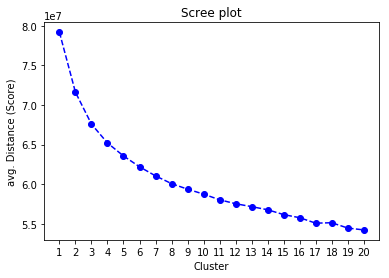

In [113]:
# plotting a scree plot (Elbow Method
#at some point, adding new clusters will no longer create a substantial decrease in the average distance

plt.plot(cluster, avg_distance, linestyle='--', marker='o', color='b');
plt.title('Scree plot')
plt.xlabel('Cluster')
plt.xticks(cluster)
plt.ylabel('avg. Distance (Score)');

At cluster 17, adding new clusters will no longer create a substantial decrease in the average distance.

In [110]:
# Re-fit the k-means model with 17 clusters and obtain
# clusteaar predictions for the general population demographics data.

#instiate the model
k_means = KMeans(n_clusters=17) 
# fit the model and predict cluster labels
predict_labels_azdias = k_means.fit_predict(azdias_clean_imputed_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [111]:
# Load in the customer demographics data.
customers = azdias = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [133]:
#apply the same feature wrangling, selection, and engineering steps to the customer demographics
#using the clean_data()
customers_clean, customers_over_mean = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [121]:
print(customers_clean.shape)
customers_clean.head()

(139424, 130)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_INTL_2015_household,CAMEO_INTL_2015_status,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,3.0,3.0,2.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,1,0,0,0,0,4.0,4.0,2.0,1.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,1,0,0,0,0,0,4.0,4.0,1.0,0.0
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,1,0,0,1.0,1.0,4.0,0.0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,1,0,0,0,0,4.0,4.0,2.0,1.0


In [114]:
# applying imputation on the missing values (strategy='mean')
imputer_mean = Imputer(missing_values=np.nan, strategy='mean', axis=0)
customers_clean_imputed = pd.DataFrame(imputer_mean.fit_transform(customers_clean))
# restoring the data frame
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index
customers_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_INTL_2015_household,CAMEO_INTL_2015_status,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,1.0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0
3,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,0.0
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,0.0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0


In [115]:
# scaling the customers data 
scaler = StandardScaler()
customers_clean_imputed_scaled = pd.DataFrame(scaler.fit_transform(customers_clean_imputed))
# restoring the data frame
customers_clean_imputed_scaled.columns = customers_clean.columns
customers_clean_imputed_scaled.index = customers_clean.index

In [116]:
# applying PCA to the data with only 62 components
pca, customers_clean_imputed_scaled_pca = do_pca (62, customers_clean_imputed_scaled)

In [117]:
#fit the k-means model with 17 clusters and obtain
# clusteaar predictions for the customers demographics data.

#instiate the model
k_means = KMeans(n_clusters=17) 
# fit the model and predict cluster labels
predict_labels_customers = k_means.fit_predict(customers_clean_imputed_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [200]:
# generating a cluster for the missing data points for the general popuation and customer data set

# array with missing values
azdias_over_mean_array = np.full((azdias_over_mean.shape[0],), -1)

# join predicted labels for general population with array of missing values
predict_all_labels_azdias = np.concatenate([predict_labels_azdias, azdias_over_mean_array])

# array with missing values
customers_over_mean_array = np.full((customers_over_mean.shape[0],), -1)
#j oin predicted labels for customer population with array of missing values
predict_all_labels_customers = np.concatenate([predict_labels_customers, customers_over_mean_array])

#(inspiration: https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb)

In [242]:
# proportion of data points in each cluster for the customer data
customer_cluster = pd.Series(predict_all_labels_customers).value_counts(normalize=True)
customer_cluster = pd.DataFrame(customer_cluster,columns=['proportion'])
# proportion of data points in each cluster for the general population
general_cluster = pd.Series(predict_all_labels_azdias).value_counts(normalize=True)
general_cluster = pd.DataFrame(general_cluster,columns=['proportion'])

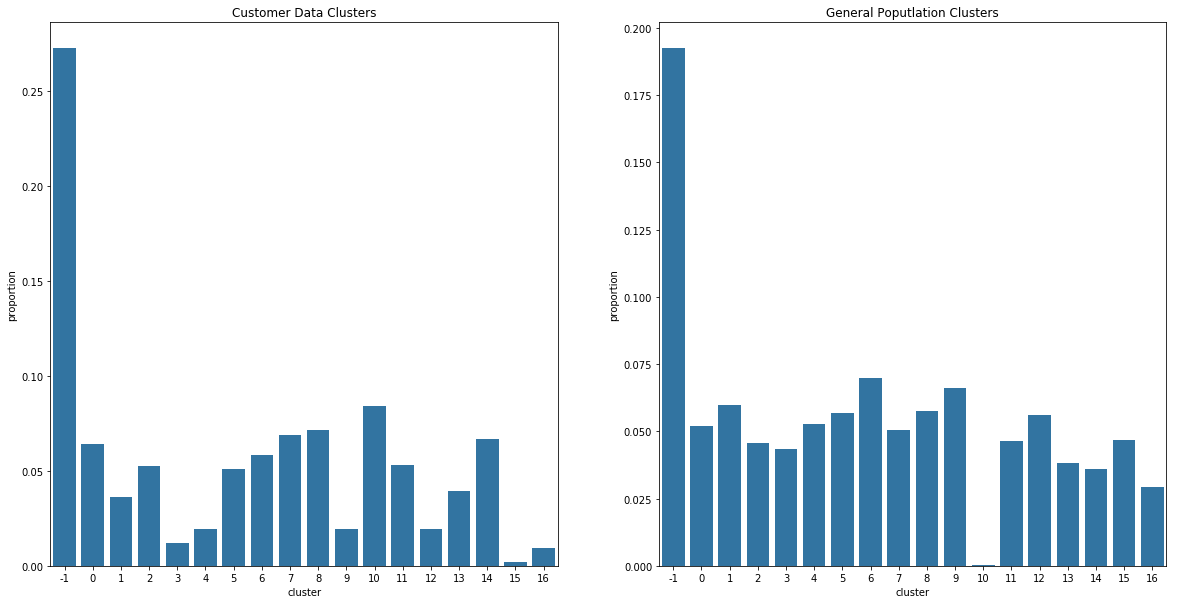

In [243]:
# plotting the proportion of data points in each cluster for the general population and the customer data
fig = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
    
plt.subplot(1, 2, 1)
sns.barplot(x=customer_cluster.index, y=customer_cluster.proportion, hue=None, data=None, color=base_color)
plt.title('Customer Data Clusters')
plt.xlabel('cluster')

plt.subplot(1, 2, 2)
sns.barplot(x=general_cluster.index, y=general_cluster.proportion, hue=None, data=None, color=base_color)
plt.title('General Poputlation Clusters')
plt.xlabel('cluster')

plt.show()

In [314]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
representation_data_customer = (customer_cluster.proportion - general_cluster.proportion)*100
print('clusters that are overrepresented (in &) in the customer dataset:' + "\n" + '{}'.format(representation_data_customer.sort_values(ascending=False).head(9)))
print('\n')
print('clusters that are underrepresented (in &) in the customer dataset:' + "\n" + '{}'.format(representation_data_customer.sort_values(ascending=False).tail(9)))

clusters that are overrepresented (in &) in the customer dataset:
 10    8.353662
-1     7.997330
 14    3.087890
 7     1.832620
 8     1.407126
 0     1.176078
 2     0.712042
 11    0.673960
 13    0.118994
Name: proportion, dtype: float64


clusters that are underrepresented (in &) in the customer dataset:
5    -0.615157
6    -1.147825
16   -2.002801
1    -2.337599
3    -3.134842
4    -3.326619
12   -3.643303
15   -4.487925
9    -4.663629
Name: proportion, dtype: float64


I will have a look at **cluster 10** (which is mostclusters that are most overrepresented in the customer dataset) and **cluster 9** (which is mostclusters that are most underrepresented in the customer dataset).
By doing so, I will compare the two clusters in Terms of **Gender** (ANREDE_KZ), **Age** (ALTERSKATEGORIE_GROB), **net income** (HH_EINKOMMEN_SCORE), **tradional-minded** (SEMIO_TRADV), **Distance to city center** (downtown) (INNENSTADT).

In [415]:
# applying .inverse_transform() to transform centroids back to the original data
cluster_features = scaler.inverse_transform(pca.inverse_transform(k_means.cluster_centers_))
cluster_features = pd.DataFrame(original_data_features, columns=customers_clean_imputed_scaled.columns)
# I will have a closer look at cluster 10 ()
cluster_features.loc[10]

ALTERSKATEGORIE_GROB              3.980198
ANREDE_KZ                         0.973056
FINANZ_MINIMALIST                 4.960549
FINANZ_SPARER                     1.071986
FINANZ_VORSORGER                  4.903662
FINANZ_ANLEGER                    0.910692
FINANZ_UNAUFFAELLIGER             1.713946
FINANZ_HAUSBAUER                  2.269688
GREEN_AVANTGARDE                  0.982011
HEALTH_TYP                        1.220487
RETOURTYP_BK_S                    4.234403
SEMIO_SOZ                         4.943449
SEMIO_FAM                         4.457919
SEMIO_REL                         3.509210
SEMIO_MAT                         4.695736
SEMIO_VERT                        6.746365
SEMIO_LUST                        6.665094
SEMIO_ERL                         3.532655
SEMIO_KULT                        4.632973
SEMIO_RAT                         1.949562
SEMIO_KRIT                        2.558513
SEMIO_DOM                         2.691773
SEMIO_KAEM                        1.601031
SEMIO_PFLIC

Overrepresentation of an cluster (compared to the general popultation suggests that the people in that cluster to be a target audience for the company.
cluster 10 represents men who are over 46 years old, with a very high income, who live 5 - 10 km to the city center and who are very high affinity to a traditional-mined type.

In [395]:
# I will have a closer look at cluster 9
cluster_features.loc[9]

ALTERSKATEGORIE_GROB              2.614717
ANREDE_KZ                         1.443464
FINANZ_MINIMALIST                 4.280822
FINANZ_SPARER                     1.424717
FINANZ_VORSORGER                  4.638254
FINANZ_ANLEGER                    1.621155
FINANZ_UNAUFFAELLIGER             1.759391
FINANZ_HAUSBAUER                  2.785521
GREEN_AVANTGARDE                  0.427778
HEALTH_TYP                        2.120290
RETOURTYP_BK_S                    3.829281
SEMIO_SOZ                         4.143150
SEMIO_FAM                         4.252717
SEMIO_REL                         4.337170
SEMIO_MAT                         3.807897
SEMIO_VERT                        4.397546
SEMIO_LUST                        5.082418
SEMIO_ERL                         4.808148
SEMIO_KULT                        4.212526
SEMIO_RAT                         3.968052
SEMIO_KRIT                        4.378030
SEMIO_DOM                         4.402130
SEMIO_KAEM                        4.051955
SEMIO_PFLIC

Underrepresentation of an cluster (compared to the general popultation) suggests that the group of persons are outside of the target demographic
cluster 9 represents men who are between 30-46 years old, with a high income, who live 5 - 10 km to the city centerand who are not as traditional minded as the target group (high affinity).

All in all, men in Cluster 9 are younger, no so traditional, and have a lower income than men in target group of the company (cluster 10).

### Discussion 3.3: Compare Customer Data to Demographics Data

I compared the most under- and overrepresented clusters 9 and 10 (compared to the general popultation) in Terms of **Gender** (ANREDE_KZ), **Age** (ALTERSKATEGORIE_GROB), **net income** (HH_EINKOMMEN_SCORE), **tradional-minded** (SEMIO_TRADV), **Distance to city center** (downtown) (INNENSTADT).

#### Cluster 10:
Overrepresentation of an cluster (compared to the general popultation) suggests that the people in that cluster to be a target audience for the company.
cluster 10 represents men who are over 46 years old, with a very high income, who live 5 - 10 km to the city center and who are very high affinity to a traditional-mined type.

#### Cluster 9:
Underrepresentation of an cluster (compared to the general popultation) suggests that the group of persons are outside of the target demographic of the company.
cluster 9 represents men who are between 30-46 years old, with a high income, who live 5 - 10 km to the city centerand who are not as traditional minded as the target group (high affinity).

All in all, men in Cluster 9 (who are not interesting for the company) are younger, not so traditional, and have a lower income than men in target group of the company (cluster 10)
